Lab 1: Computational neuron and simple motifs

In this lab, we will move from a biological neuron to a simpler phenomenological neuron in which we retain the key features of a neuron i.e. spikes and spike patterns. 

We will use a neuron model called the adaptive leaky-and-integrate firing neuron. Using this neuron you will get more insights into the origin of different types of spikes patterns. Then we will construct small circuits with two or three neurons and you will see interaction among neurons. 

(The tutorial is inspired by the Neuronal Dynamics book from Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski. https://neuronaldynamics.epfl.ch/online/index.html)

In [3]:
#@title Run the following to initialize lab environment.
import matplotlib.pyplot as plt         # import matplotlib
from matplotlib.widgets import Slider
import numpy as np                      # import numpy
import ipywidgets as widgets            # interactive display

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)
my_layout = widgets.Layout()

# Auto Reloading
%load_ext autoreload
%autoreload 2

debug = 'google.colab' not in str(get_ipython())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#@title Run the following to download necessary files.
if not debug:
    import os, sys

    # clone respository
    user = "michaelglh"
    repo = "STG"
    if os.path.isdir(repo):
        !rm -rf {repo}
    !git clone https://github.com/{user}/{repo}.git

    # add path to system
    src_dir = ""
    path = f"{repo}/{src_dir}"
    if not path in sys.path:
        sys.path.insert(1, path)

    !pip install ipympl --quiet

from lib.neuron import LIF
from lib.input import Poisson_generator, Gaussian_generator, Current_injector
from lib.conn import Simulator
from lib.helper import plot_volt_trace
    
%matplotlib widget

Cloning into 'STG'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 137 (delta 64), reused 118 (delta 45), pack-reused 0
Receiving objects: 100% (137/137), 3.05 MiB | 24.59 MiB/s, done.
Resolving deltas: 100% (64/64), done.


### Firing patterns of single neuron

Here we have a simple neuron model with 5 parameters. Two of them are just the parameters for LIF neuron and three of them captures the adaptation behavior. In addition to these parameters, the input level of current injection can be changes. So we essentially 6 parameters to control this single neuron.   

John von Neumann famously said that with four parameters I can fit an elephant and with six I can make it wiggle its trunk. Well, let's see what we can do with six parameters in terms of generating biologically plausible firing patterns of a neuron.

interactive(children=(FloatSlider(value=20.0, description='tau_m', max=20.0, min=5.0, step=1.0), FloatSlider(v…

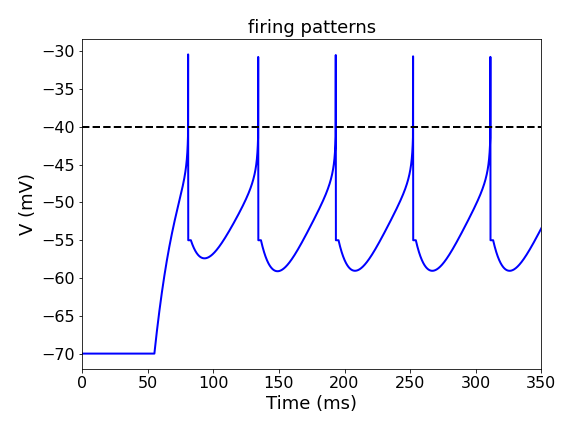

In [5]:
#@title Run the following to start the simulation of single neuron { vertical-output: true }
T, dt = 5e2, 0.1    # simulation period(ms), step size(ms)
wt, dl = 1., 5.
rt = 65.

# simualtor
h = Simulator(dt=dt)

# neurons
nrn = LIF(sim=h)
nrn.g_L = 2.
nrn.E_L = -70.
nrn.V_th = -40.

tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron, 
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron, 
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron, 
                 'delayed_neuron': delayed_neuron, 'my_neuron': tonic_neuron}
# tonic
nrn.tau_m = 20.
nrn.tau_w = 30.
nrn.b = 3
nrn.V_reset = -55.

# # adpating
# nrn.tau_m = 20.
# nrn.tau_w = 100.
# nrn.b = 0.5
# nrn.V_reset = -55.

# # initial bursting
# nrn.tau_m = 10.
# nrn.tau_w = 100.
# nrn.b = 1.
# nrn.V_reset = -50.

# # bursting
# nrn.tau_m = 5.
# nrn.tau_w = 100.
# nrn.b = 1
# nrn.V_reset = -46.

# # irregular
# nrn.tau_m = 10.0
# nrn.a = -0.01
# nrn.tau_w = 50.
# nrn.b = 1.2
# nrn.V_reset = -46.

# # transient
# nrn.tau_m = 5.
# nrn.a = 0.05
# nrn.tau_w = 100.
# nrn.b = 0.7
# nrn.V_reset = -60.

# # delayed
# nrn.tau_m = 5.
# nrn.a = -0.1
# nrn.tau_w = 100.
# nrn.b = 1.0
# nrn.V_reset = -60.
# rt = 5.

# constant current injection
cur_in = Current_injector(sim=h, Is=np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))]))
nrn.connect(cur_in, {'ctype':'static', 'weight': wt, 'delay':dl})

# updating parameters
def update(tau_m=20., a=0., tau_w=30., b=3., V_reset=-55., Icur=65., neuron_type='my_neuron'):
    if neuron_type is 'my_neuron':
      neuron_params['my_neuron'] = {'tau_m':tau_m, 'a':a, 'tau_w':tau_w, 'b':b, 'V_reset':V_reset}
    nrn.update(neuron_params[neuron_type])

    cur_in.Is = np.concatenate([np.zeros(int(T/dt*0.1)), Icur*np.ones(int(T/dt*0.9))])

    # simulate
    h.run(T)

    # visualize
    plt.clf()
    plt.title('firing patterns')
    plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrn.V_th}
    plot_volt_trace(plt_par, nrn.v, np.array(nrn.spikes['times']))
    plt.xlim([0, 350])

    plt.tight_layout()
    if not debug:
        display(fig)

fig = plt.figure()
widgets.interact(update, neuron_type=neuron_params.keys(), tau_m=(5.0, 20.0, 1.0), a=(-0.1, 0.1, 0.01), tau_w=(30., 120., 10.), b=(0., 3., 0.1), V_reset=(-60., -40., 2.), Icur=(5., 70., 5.));

## Describe
- How are the adaptation parameters $a, b, \tau_w$ affecting the membrane potential?
- Can you tune all the six parameters to find some unique firing patterns? 
- What are the most important variables of the model, in the sense that they change the firing pattern in a qualitatively different manner e.g. from regular spiking to bursting?
- Which other spike patterns you expected the model to exhibit but it could not?

##THINK
In the above you may have noticed that $V_{reset}$ and $\tau_w$ are two interesting variable that can affect the firing pattern. 

- How do you think the variable $\tau_w$ affects the firing pattern of the neuron. We can already tell you that $\tau_w$ affects the dynamics of the variable $w$. But the question is whether $w$ is a positive contribution to the neuron membrane potential or negative? 
- We often try to describe a neuron with its input current and output firing rate curve. Can we define such a relationship for a neuron when it is either bursting or showing firing rate adapataion. If not, what can be do to describe the neuron's behavior?

Neuron dynamaics: let's open the balckbox of the neuron

$$\tau_m \frac{dV}{dt} = -(V-V_{rest}) + \Delta_T exp(\frac{V-V_{rh}}{\Delta_T}) - Rw + RI(t)$$
$$\tau_w \frac{dw}{dt} = a(V-V_{rest}) -w + b
\tau_w \sum_{t^{(f)}} \delta(t-t^{(f)})$$

It's described by two variables $V$ and $w$ which denote the membrane potential and adaptation current. The parameters $a, b, \tau_w$ controls the behavior of adaptation where $a$ controls sub-threshold adaptation and $b, \tau_w$ controls spike adaptation. For detailed explanation of this mode, refer tht book we mentioned at the beginning.

### Functional neural motifs

<img src="https://github.com/michaelglh/STG/blob/master/figs/EI.png?raw=1" alt="EI motif" width="300"/>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


interactive(children=(Dropdown(description='Itype', options=('Icur', 'Gaussian', 'Poisson'), value='Icur'), Dr…

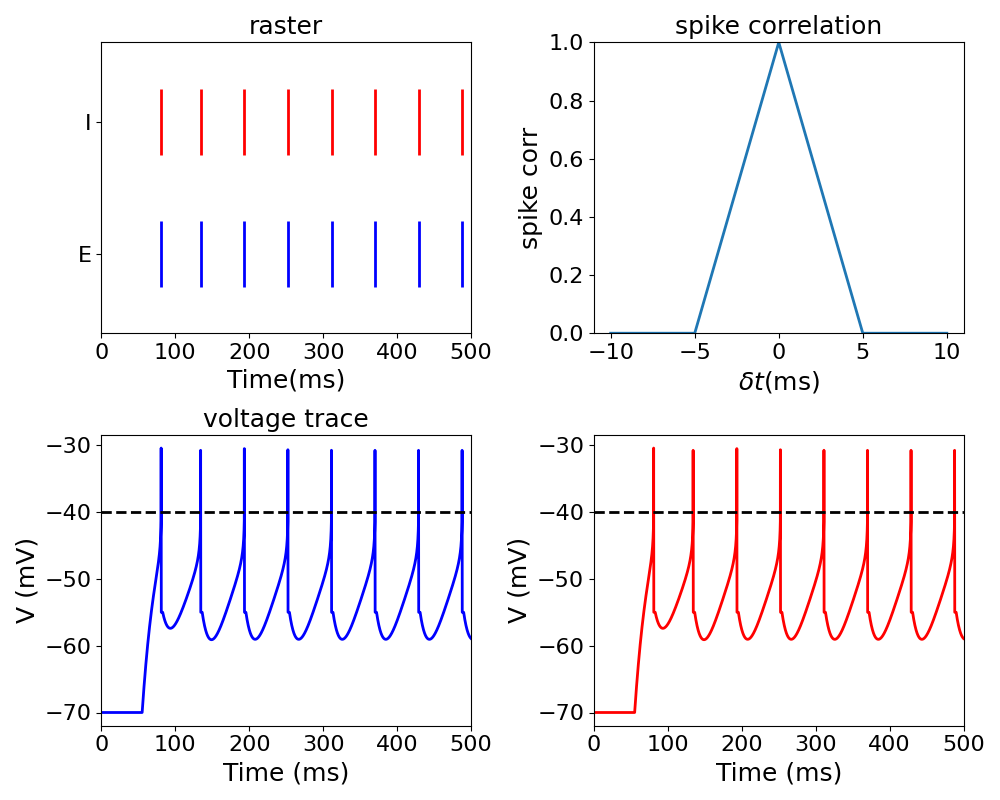

In [32]:
#@title Run the following to start E-I pair simulation { vertical-output: true }
# E-I motif
N = 2                  # number of neurons
wt, dl = 1, 5.

# updating parameters
def update_EI(Itype='Icur', neuron_E='tonic_neuron', neuron_I='tonic_neuron', J_ei=0., J_ie=0.):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]

    nrns[0].update(neuron_params[neuron_E])
    nrns[1].update(neuron_params[neuron_I])

    # background noise
    if Itype == 'Icur':
        noises = [Current_injector(sim=h, Is=np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))])) for _ in range(N)]
    elif Itype == 'Gaussian':
        noises = [Gaussian_generator(sim=h, mean=rt, std=rt) for _ in range(N)]
    elif Itype == 'Poisson':
        noises = [Poisson_generator(sim=h, rate=250) for _ in range(N)]
    else:
        print('Invalid input')
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'static', 'weight':wt, 'delay':dl})

    # recurrent connections
    # tps = [['facilitate']*N]*N
    tps = [['static']*N]*N
    con = np.array([[0., J_ei],
                    [J_ie, 0.]])
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # # extract data
    # bints = np.arange(0, T+1, 20.)
    # psths = [np.histogram(nrn.spikes['times'], bins=bints)[0] for nrn in nrns]

    # coincidence
    binwindow = int(5.0/dt)
    spike_trains = [nrn.states for nrn in nrns]
    bin_spikes = [np.convolve(strain, np.ones(binwindow), 'same') for strain in spike_trains]
    deltats = np.linspace(-10., 10., 21)
    coins = []
    for delay in deltats:
        index = int(delay/dt)
        if index > 0:
            coins.append(np.dot(bin_spikes[0][:-index], bin_spikes[1][index:]))
        elif index < 0:
            coins.append(np.dot(bin_spikes[1][:index], bin_spikes[0][-index:]))
        else:
            coins.append(np.dot(bin_spikes[0], bin_spikes[1]))
    coins = np.array(coins)/np.sqrt(np.dot(bin_spikes[0], bin_spikes[0]))/np.sqrt(np.dot(bin_spikes[1], bin_spikes[1]))

    # visualize
    plt.clf()
    cs = ['b', 'r']
    plt.subplot(2,N,1)
    plt.title('raster')
    for nrn, c, l in zip(nrns, cs, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c)
    plt.xlabel('Time(ms)')
    plt.yticks([0, 2], ['E', 'I'])
    plt.xlim([0., T])

    plt.subplot(2,N,2)
    plt.title('spike correlation')
    plt.plot(deltats, coins)
    plt.xlabel(r'$\delta t$(ms)')
    plt.ylabel('spike corr')
    plt.ylim([0, 1])

    # voltage trace
    for id, c in zip(range(N), cs):
        plt.subplot(2,N,id+N+1)
        if id == 0:
            plt.title('voltage trace')
        plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrns[id].V_th}
        plot_volt_trace(plt_par, nrns[id].v, np.array(nrns[id].spikes['times']), c=c)
        plt.xlim([0., T])

    plt.tight_layout()
    if not debug:
        display(fig_EI)

try:
  print(fig_EI)
except:
  fig_EI, axes = plt.subplots(2,N,figsize=(5*N,8))
widgets.interact(update_EI, Itype=['Icur', 'Gaussian', 'Poisson'], 
                 neuron_E=neuron_params.keys(), neuron_I=neuron_params.keys(), 
                 J_ie=(0.0, 50.0, 0.1), J_ei=(-50., 0., 0.1));

<img src="https://github.com/michaelglh/STG/blob/master/figs/EII.png?raw=1" alt="EII motif" width="300"/>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


interactive(children=(Dropdown(description='Itype', options=('Icur', 'Gaussian', 'Poisson'), value='Icur'), Dr…

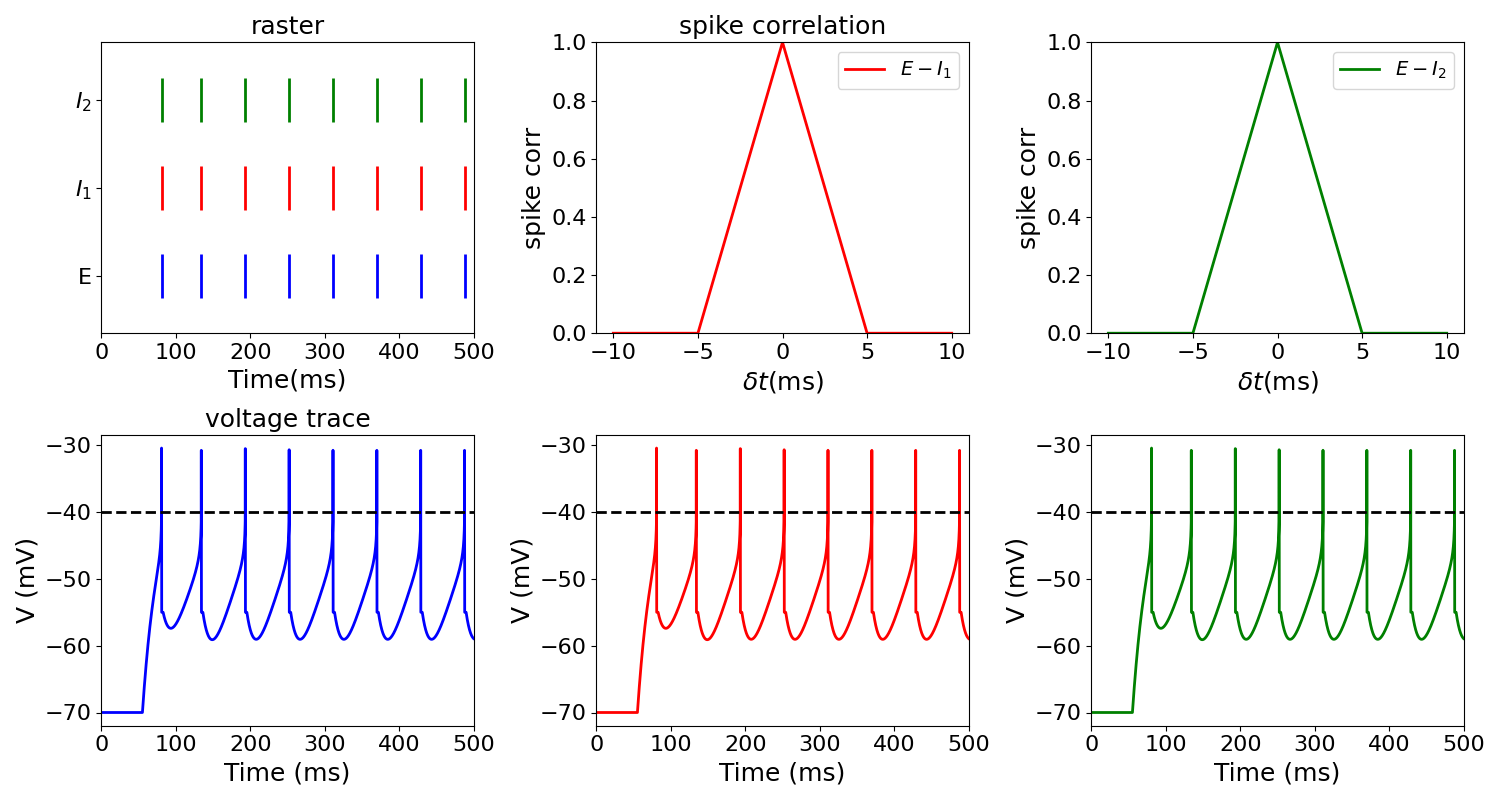

In [34]:
#@title Run the following start E-I-I triplet simulation { vertical-output: true }
# Triplet
N = 3                  # number of neurons
wt, dl = 1., 5.

# updating parameters
def update_EII(Itype='Icur', neuron_E='tonic_neuron', neuron_I1='tonic_neuron', neuron_I2='tonic_neuron', J_E1=0., J_E2=0., J_21=0.):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    nrns[0].update(neuron_params[neuron_E])
    nrns[1].update(neuron_params[neuron_I1])
    nrns[2].update(neuron_params[neuron_I2])

    # background noise
    if Itype == 'Icur':
        noises = [Current_injector(sim=h, Is=np.concatenate([np.zeros(int(T/dt*0.1)), rt*np.ones(int(T/dt*0.9))])) for _ in range(N)]
    elif Itype == 'Gaussian':
        noises = [Gaussian_generator(sim=h, mean=rt, std=rt) for _ in range(N)]
    elif Itype == 'Poisson':
        noises = [Poisson_generator(sim=h, rate=250) for _ in range(N)]
    else:
        print('Invalid input')
    for noise, nrn in zip(noises, nrns):
        nrn.connect(noise, {'ctype':'static', 'weight':wt, 'delay':dl})

    # recurrent connections
    # tps = [['facilitate']*N]*N
    tps = [['static']*N]*N
    con = np.array([[0., J_E1, J_E2],
                    [0., 0., 0.],
                    [0., J_21, 0.]])
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # coincidence
    binwindow = int(5.0/dt)
    spike_trains = [nrn.states for nrn in nrns]
    bin_spikes = [np.convolve(strain, np.ones(binwindow), 'same') for strain in spike_trains]
    deltats = np.linspace(-10., 10., 21)
    coins_all = []
    for src, tar in zip([0, 0], [1, 2]):
        coins = []
        for delay in deltats:
            index = int(delay/dt)
            if index > 0:
                coins.append(np.dot(bin_spikes[src][:-index], bin_spikes[tar][index:]))
            elif index < 0:
                coins.append(np.dot(bin_spikes[tar][:index], bin_spikes[src][-index:]))
            else:
                coins.append(np.dot(bin_spikes[src], bin_spikes[tar]))
        coins = np.array(coins)/np.sqrt(np.dot(bin_spikes[src], bin_spikes[src]))/np.sqrt(np.dot(bin_spikes[tar], bin_spikes[tar]))
        coins_all.append(coins)

    # visualize
    plt.clf()
    cs = ['b', 'r', 'g']  
    plt.subplot(2,N,1)
    plt.title('raster')
    for nrn, c, l in zip(nrns, cs, range(N)):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c)
    plt.xlabel('Time(ms)')
    plt.yticks(np.array(range(N))*2, ['E', r'$I_1$', r'$I_2$'])
    plt.xlim([0., T])

    # rate plots of population
    plt.subplot(2,N,2)
    plt.title('spike correlation')
    plt.plot(deltats, coins_all[0], 'r', label=r'$E-I_1$')
    plt.xlabel(r'$\delta t$(ms)')
    plt.ylabel('spike corr')
    plt.ylim([0,1])
    plt.legend()

    plt.subplot(2,N,3)
    plt.plot(deltats, coins_all[1], 'g', label=r'$E-I_2$')
    plt.xlabel(r'$\delta t$(ms)')
    plt.ylabel('spike corr')
    plt.ylim([0,1])
    plt.legend()

    # voltage trace
    for id, c in zip(range(N), cs):
        plt.subplot(2,N,id+N+1)
        if id == 0:
            plt.title('voltage trace')
        plt_par = {'dt':dt, 'range_t':np.arange(0., T, dt), 'V_th':nrns[id].V_th}
        plot_volt_trace(plt_par, nrns[id].v, np.array(nrns[id].spikes['times']), c=c)
        plt.xlim([0., T])

    plt.tight_layout()
    if not debug:
        display(fig_EII)

try:
  print(fig_EII)
except:
  fig_EII, axes = plt.subplots(2, N,figsize=(5*N,8))
widgets.interact(update_EII, Itype=['Icur', 'Gaussian', 'Poisson'], 
                 neuron_E=neuron_params.keys(), neuron_I1=neuron_params.keys(), neuron_I2=neuron_params.keys(), 
                 J_E1=(-50., 0., 0.1), J_E2=(-50., 0., 0.1), J_21=(-50., 0., 0.1));